## Домашнє завдання:  kNN. Кросвалідація і тюнинг гіперпараметрів

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

Необхідні імпорти

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from datetime import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
file_name = '/content/drive/MyDrive/ML/data/bccp/train.csv'

In [ ]:
%load_ext autoreload
%autoreload 2
from process_bank_churn import preprocess_data

In [ ]:
raw_train_data = pd.read_csv(file_name)
raw_train_data.head(3)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.0,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.0,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.0,3.0,0.0,0.0,179655.87,1.0


In [ ]:
X_train, y_train, X_val, y_val, input_cols, scaler, encoder = preprocess_data(
    raw_df=raw_train_data,
    target_col = 'Exited',
    unnecessary_columns=['Surname', 'id',	'CustomerId'],
    scaler_numeric = False
    )

In [ ]:
display(X_train.head(3)), display(X_val.head(3))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,682.0,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,1.0,0.0,0.0,0.0,1.0
10393,684.0,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,1.0,0.0,0.0,1.0,0.0
80,705.0,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0,1.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6490,714.0,46.0,1.0,115764.32,4.0,1.0,1.0,72945.32,0.0,1.0,0.0,0.0,1.0
3646,593.0,41.0,5.0,0.00,2.0,1.0,1.0,38196.24,1.0,0.0,0.0,0.0,1.0
5306,731.0,38.0,2.0,0.00,2.0,0.0,1.0,116971.05,1.0,0.0,0.0,1.0,0.0


(None, None)

### Завдання 1

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

train_auc = roc_auc_score(y_train, knn_model.predict_proba(X_train)[:, 1])
val_auc = roc_auc_score(y_val, knn_model.predict_proba(X_val)[:, 1])

print(f"Train ROC-AUC: {train_auc:.4f}; Validation ROC-AUC: {val_auc:.4f}")

Train ROC-AUC: 0.8238; Validation ROC-AUC: 0.5734


**Спостереження**:

Бачимо, що різниця метрики ROC-AUC для тренувального та валідаційного наборів даних занадто велка. Отже модель має слабку генералізацію.

Скоріше наявний high variance, адже якість передбачення на тренувальних данних значно вища, в і порівнянні дуже слабка на валідаційних.

### Завдання 2

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [ ]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 50)}

knn_gs = GridSearchCV(knn, params_knn, cv=5, scoring='roc_auc', n_jobs=-1)
knn_gs.fit(X_train, y_train)
print(f"Найкраще значення параметру: {knn_gs.best_params_};\nНайкращий score {knn_gs.best_score_}")

Найкраще значення параметру: {'n_neighbors': 47};
Найкращий score 0.5930238646361223


In [ ]:
knn_best = knn_gs.best_estimator_

In [ ]:
train_auc = roc_auc_score(y_train, knn_best.predict_proba(X_train)[:, 1])
val_auc = roc_auc_score(y_val, knn_best.predict_proba(X_val)[:, 1])

print(f"Train ROC-AUC: {train_auc:.4f}; Validation ROC-AUC: {val_auc:.4f}")

Train ROC-AUC: 0.6574; Validation ROC-AUC: 0.6191


**Спостереження**:

Можемо зробити висновок, що модель покращилась, оскільки значення ROC-AUC стало вищим ніж в попередній моделі, та різниця ROC-AUC між передбаченями на  тренувальному та валідаційному датасетах стала меншою.


Для найпростішої моделі дерев прийнятя рішень були отримані значення ROC-AUC на тренувальних даних - 1.0000, а на валідаційних - 0.7700, що говорить нам про явне перенавчання моделі. Але в данному випадку ми позбавись від сильного перенавчання, але якість моделі все одно не дуже висока. Хоча в минулй моделі присутнє явне перенавчання, все ж таки вона краще генералізує - 0.7700 проти 0.6191 (Значення на валідаціних наборах).

Якщо порівнювати з моделлю дерев прийняття рішень, що була натренована зі значенням гіперпараметру max_depth=5, де було отримано ROC-AUC на тренувальних даних - 0.9257 та на валідаційних - 0.9219, то можемо впевнено сказати, що якість найкращої обраної моделі значно гірший.

### Завдання 3

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': range(1, 21, 2),
    'max_leaf_nodes': range(2, 11)
}

grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Найкращі параметри: {grid_search.best_params_}; \nНайкращий score: {grid_search.best_score_} ; \nЧас на підбір парметрів: {elapsed_time}')

Найкращі параметри: {'max_depth': 5, 'max_leaf_nodes': 10}; 
Найкращий score: 0.9013929183420709 ; 
Час на підбір парметрів: 5.913150787353516


In [ ]:
model_best = grid_search.best_estimator_

In [ ]:
train_auc = roc_auc_score(y_train,  model_best.predict_proba(X_train)[:, 1])
val_auc = roc_auc_score(y_val, model_best.predict_proba(X_val)[:, 1])

print(f"Train ROC-AUC: {train_auc:.4f}; Validation ROC-AUC: {val_auc:.4f}")

Train ROC-AUC: 0.9015; Validation ROC-AUC: 0.9002


**Спостереження**:

Отримана модель має достатньо високі значення метрики ROC-AUC, які не сильно відрізняються для тренувального та валідаційних наборів даних, що говорить про гарну генералізацію.

Модель дерева прийняття рішень з минулого домашнього завдання, що підбиралась в ручну мала наступні гіперпараметри: `max_depth=8, max_leaf_nodes=45`. Значення метрики ROC-AUC: `Train 0.9305; Validation 0.9248`.

Отримана модел за добопомогою GridSearchCV є трошки гіршою, так як пошуки оптимального max_leaf_nodes обмежені значенням 10.

### Завдання 4

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [ ]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [ ]:
model_rs = DecisionTreeClassifier(random_state=42)

In [ ]:
random_search = RandomizedSearchCV(
    estimator=dt_model, param_distributions=params_dt, n_iter=40,
    cv=3, scoring='roc_auc', random_state=42, n_jobs=-1
)

In [ ]:
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Найкращі параметри: {random_search.best_params_} \nНайкращий score: {random_search.best_score_} ; \nЧас на підбір парметрів: {elapsed_time}')

Найкращі параметри: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'} 
Найкращий score: 0.910864318350194 ; 
Час на підбір парметрів: 1.3520917892456055


In [ ]:
model_best_rs = random_search.best_estimator_

In [ ]:
train_auc = roc_auc_score(y_train, model_best_rs.predict_proba(X_train)[:, 1])
val_auc = roc_auc_score(y_val, model_best_rs.predict_proba(X_val)[:, 1])

print(f"Train ROC-AUC: {train_auc:.4f}; Validation ROC-AUC: {val_auc:.4f}")

Train ROC-AUC: 0.9169; Validation ROC-AUC: 0.9166


**Спостереження**:

- Модель має достатньо високі значення метрики ROC-AUC, та достатню малу різницю її значення між тренувальними та валідаційними даними.

- Модель знайдена з `RandomizedSearchCV` є трохи кращою за модель знайдену з `GridSearch`.

- В результаті пошуку оптимальних параметрів, були знайдені різні набори, так наприклад пареметрів, що були знайдені за допомогою `RandomizedSearchCV` - більше, ніж за допомогою `GridSearchCV`, адже ми задавали різну сітку параметрів.

- `splitter`: Для `GridSearch` за замовчуванням залишили `best`, а з `RandomizedSearchCV` було обрано `best`. Отже `RandomizedSearchCV` протестував і `best`, і `random`, але виявив, що `best` дає кращий результат.

- `min_samples_split`: Для `GridSearchCV` даний параметр не налаштовувася  налаштовувався, тож використовувалось значення за замовчуванням `2`, а  `RandomizedSearchCV` обрав як найкраще значення `20`. Оскільки значення параметру це мінімальне число об'єктів, необхідне для того, щоб узел дерева міг би розщепитися, то таким чином значення 20 запобігає дуже малим розбиттям, і скоріше за все буде знижувати імовірність перенавчання.

- `min_samples_leaf`: Для `GridSearchCV` використовувалось значення за замовчуванням `1`, а `RandomizedSearchCV` обрав значення `2`, отже ожен кінцевий вузол повинен містити щонайменше 2 зразки, таким чином модель буде уникати занадто дрібних розбиттів вузлів.

- `max_leaf_nodes`: Також з `GridSearchCV` було обрано меншу кількість вузлів 10 проти 14,  в допустимих параметрах для `GridSearchCV` така комбінація була оптимальнішою.

- `max_depth`: Бачимо, що дерево є глибшим у випадку `RandomizedSearchCV`, 16 проти 5. Так як `GridSearchCV` мав вужчий діапазон значення 5 могло бути найоптимальнішим.

- `criterion`: Критерій розбиття для `GridSearchCV` - був за замовченням з `DecisionTreeClassifier` - `gini`, а з `RandomizedSearchCV` було визначено, що за розглянутих параметрів було оптимально використати `entropy`. На данному наборі даних краще спроцювало налайштування з `entropy`.

- `max_features`:  Для `GridSearchCV` використовувалось значення за замовчуванням `None`, `RandomizedSearchCV` також обрав `None`.

Таким чином маємо, що Глибина дерева `max_depth` у `RandomizedSearchCV` значно більша, ніж у `GridSearchCV`. Це може свідчити про більшу складність дерева і ризик перенавчання. Однак, додаткові парматери, що розглядав   `RandomizedSearchCV` (типу min_samples_split та min_samples_leaf) компенсують це, обмежуючи розмір листків і запобігаючи надто дрібним розбиттям.
Варто відмітити, що не дивлячиь на меншу кількість параметрів GridSearchCV витратив більше часу на їх підбір, а ніж `RandomizedSearchCV`.



### Завдання 5

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [ ]:
%load_ext autoreload
%autoreload 2
from process_bank_churn import preprocess_new_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
file_name = '/content/drive/MyDrive/ML/data/bccp/test.csv'
test_df = pd.read_csv(file_name)

proc_test_df = preprocess_new_data(
    new_df = test_df,
    encoder = encoder,
    scaler = None,
    unnecessary_columns = ['Surname']
)
model = model_best_rs
proc_test_df['Exited'] = model.predict_proba(proc_test_df[input_cols])[:,1]

file_name = '/content/drive/MyDrive/ML/data/bccp/sample_submission.csv'
sample = pd.read_csv(file_name)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
sub_path = 'drive/My Drive/ML/data/bccp/lab/submission'

upd_sample = sample.copy()
upd_sample['Exited'] = upd_sample['id'].map(proc_test_df.set_index('id')['Exited'])
upd_sample.to_csv(f'{sub_path}/submission_{timestamp}.csv', index=False)

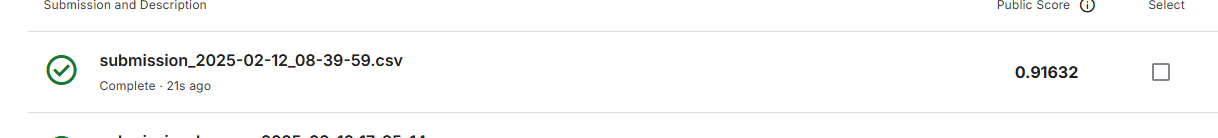

Бачимо, що скор найкращої моделі знайдений за допомогою RandomizedSearchCV - 0.91632, що трошки краще за модель з минулого домашнього завдання де отриманий скор - 0.91502.